# modeling

[참고](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

In [1]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(os.getcwd()+'/data_sales.csv')

df['time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], format='%m/%d/%Y %H:%M')
df['date'] = pd.to_datetime(df['time'].dt.date)
df = df.drop(columns = ['Date','Time']).rename(columns={'Total':'revenue'})
df.columns = [i.lower() for i in df.columns]

df = df.assign(revenue=lambda x: x['quantity']*x['unit price'],
                   weekday = lambda x: x['date'].dt.day_name())

In [3]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge
from functools import reduce

In [4]:
merge_col = ['branch','date']
y_col = 'revenue'
df_list = []
for col in ['gender','product line']:
    df_list.append(
        df.groupby(merge_col + [col]).size().rename('size').reset_index().\
        pivot_table(index = ['branch','date'], columns=[col], values='size').fillna(0).reset_index()
    )
for col in ['quantity','revenue']:
    df_list.append(
        df.groupby(merge_col)[col].sum().reset_index()
    )
df_model = reduce(lambda df1,df2: pd.merge(df1,df2, on=['branch','date']), df_list)
df_model['weekend'] = df_model['date'].apply(lambda x: 1 if x.weekday()>=5 else 0)

In [5]:
df_model = reduce(lambda df1,df2: pd.merge(df1,df2, on=['branch','date']), df_list)

In [6]:
df_model

,branch,date,Female,Male,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel,quantity,revenue
0,A,2019-01-01,3.0,2.0,1.0,1.0,0.0,0.0,1.0,2.0,37,2258.40
1,A,2019-01-02,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,7,292.43
2,A,2019-01-03,2.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,19,892.77
3,A,2019-01-04,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,15,460.25
4,A,2019-01-05,3.0,2.0,1.0,0.0,0.0,1.0,3.0,0.0,27,1928.10
...,...,...,...,...,...,...,...,...,...,...,...,...
258,C,2019-03-26,1.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,14,451.40
259,C,2019-03-27,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,9,898.38
260,C,2019-03-28,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,10,457.91
261,C,2019-03-29,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,14,938.76


In [46]:
steps = 14
shift_n = 7

df_model_ = df_model[df_model['branch']=='A'].reset_index(drop=True)
df_model_['y_obsd'] = df_model[y_col]
df_model_.loc[:,y_col] = df_model_[y_col].shift(-shift_n) # 미래 예측

df_model_.index = pd.date_range(min(df_model_['date']), max(df_model_['date']))

df_train = df_model_.iloc[:-steps, :]
df_test  = df_model_.iloc[-steps:, :]

In [47]:
df_model_

,branch,date,Female,Male,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel,quantity,revenue,y_obsd
2019-01-01,A,2019-01-01,3.0,2.0,1.0,1.0,0.0,0.0,1.0,2.0,37,650.91,2258.40
2019-01-02,A,2019-01-02,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,7,192.70,292.43
2019-01-03,A,2019-01-03,2.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,19,696.66,892.77
2019-01-04,A,2019-01-04,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,15,1582.54,460.25
2019-01-05,A,2019-01-05,3.0,2.0,1.0,0.0,0.0,1.0,3.0,0.0,27,1360.99,1928.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-26,A,2019-03-26,3.0,3.0,1.0,2.0,0.0,3.0,0.0,0.0,25,NaN,1130.80
2019-03-27,A,2019-03-27,2.0,3.0,0.0,0.0,3.0,1.0,1.0,0.0,22,NaN,1010.12
2019-03-28,A,2019-03-28,2.0,4.0,1.0,1.0,3.0,1.0,0.0,0.0,35,NaN,1574.22
2019-03-29,A,2019-03-29,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,13,NaN,931.06


In [48]:
exog_col = [col for col in df_model.columns if col not in merge_col + [y_col,'y_obsd']]

In [49]:
forecaster = ForecasterAutoreg(
                    regressor = Ridge(),
                    lags      = 7
                )

forecaster.fit(
    y    = df_train[y_col],
    exog = df_train[exog_col]
)

In [62]:
steps = 14
predictions = forecaster.predict(
                steps = steps,
                exog = df_test[exog_col]
               )
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=df_test.index)
predictions.head(10)

2019-03-17    1491.685461
2019-03-18    1302.979721
2019-03-19     621.434289
2019-03-20     930.594857
2019-03-21     595.715547
2019-03-22     710.835638
2019-03-23    1028.497709
2019-03-24     538.693673
2019-03-25     593.945709
2019-03-26    1445.225299
Freq: D, Name: pred, dtype: float64

In [63]:
from datetime import timedelta
predictions.index = predictions.index + timedelta(days = steps)

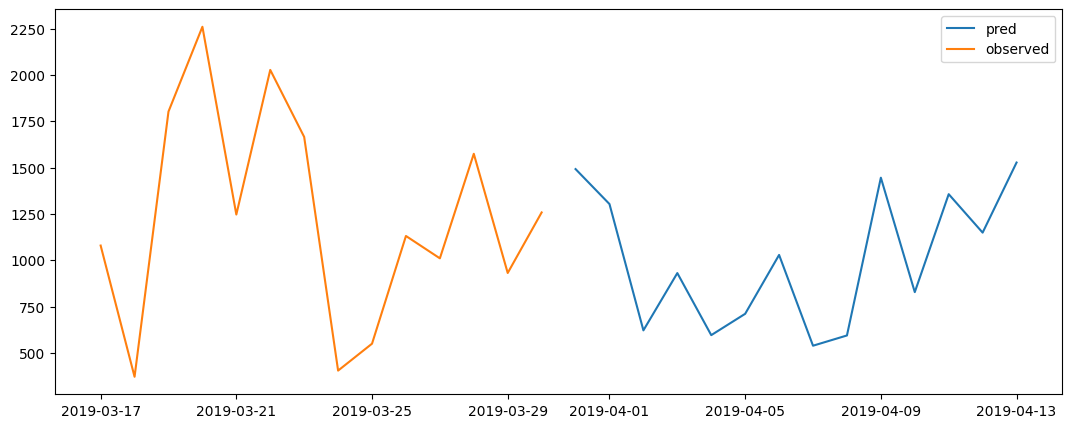

In [64]:
plt.figure(figsize=(13,5))
plt.plot(predictions, label='pred')
plt.plot(df_test['y_obsd'], label='observed')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(predictions, label='pred')
plt.plot(df_test['y_obsd'], label='observed')
plt.legend()
plt.show()